In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
warnings.filterwarnings("ignore")
from sklearn.tree import plot_tree
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')

R2: 0.7134


El r2 obtenido con la regresión lineal es de 0.7134, lo que significa que se explica el 71.34% de la variación de los datos, siendo así un buen modelo. Este fue el mejor modelo obtenido en el examen, posteriormente haremos una regresión con una red neuronal para ver los resultados.

## Random Forest

In [7]:
# Grid search 
pipeline = Pipeline([
    ('rf', RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42))
])

params = {
    'rf__max_depth': list(range(1, 15)),
    'rf__max_features': ['sqrt', 'log2', 10, len(X_train.keys())]
}

rf_grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, n_jobs=-1, scoring='r2')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(n_estimators=300,
                                                              n_jobs=-1,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13, 14],
                         'rf__max_features': ['sqrt', 'log2', 10, 32]},
             scoring='r2')

In [8]:
rf_grid.best_params_

{'rf__max_depth': 9, 'rf__max_features': 10}

In [9]:
best_model = rf_grid.best_estimator_.named_steps['rf']

predicciones_rf = best_model.predict(X_test)
r2_score(y_pred=predicciones_rf, y_true=y_test)

0.49722612313521264

## Conclusiones

### Calibración de regresión lineal

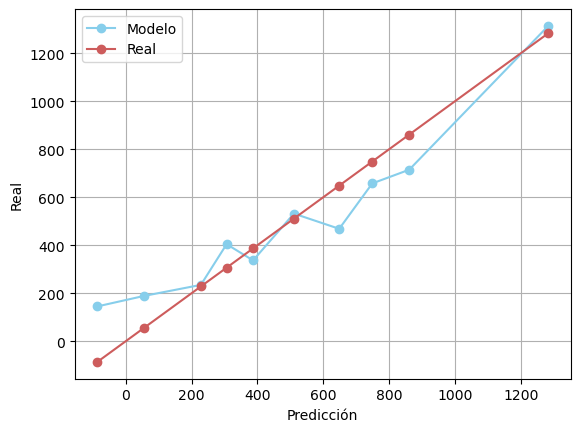

In [10]:
calibracion(y_pred, y_test, 10)

### Calibración de random forest

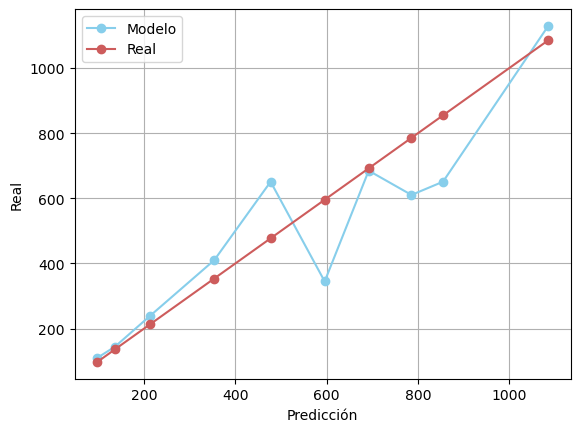

In [11]:
calibracion(predicciones_rf, y_test, 10)

### Coeficientes

In [12]:
coef_df = pd.DataFrame({
    'variable': X_train.columns,
    'coef': model.coef_
})
coef_df

,variable,coef
0,AtBat,-3.241980
1,Hits,6.351768
2,HmRun,-3.867753
3,Runs,6.923750
4,RBI,5.256982
5,Walks,2.200423
6,Years,-61.088551
7,CAtBat,-0.768608
8,CHits,0.136101
9,CHmRun,0.177146


In [13]:
model_interpretability = pd.DataFrame({
    'variable': X_train.keys(),
    'importance': best_model.feature_importances_
})
model_interpretability

,variable,importance
0,AtBat,0.033579
1,Hits,0.029437
2,HmRun,0.019574
3,Runs,0.033286
4,RBI,0.040510
5,Walks,0.039707
6,Years,0.011430
7,CAtBat,0.071092
8,CHits,0.109651
9,CHmRun,0.040763
